In [123]:
# !pip install bitsandbytes peft trl

In [124]:
import os
os.environ["WANDB_DISABLED"] = "true"

from datasets import load_dataset
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, Qwen2_5_VLProcessor, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from trl import SFTConfig, SFTTrainer

import warnings
warnings.filterwarnings("ignore")

In [125]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

MODEL_ID = "Qwen/Qwen2.5-VL-3B-Instruct"
EPOCHS = 1
BATCH_SIZE = 1
GRADIENT_CHECKPOINTING = True,  # Tradeoff between memory efficiency and computation time.
USE_REENTRANT = False,
OPTIM = "paged_adamw_32bit"
LEARNING_RATE = 2e-5
LOGGING_STEPS = 10
EVAL_STEPS = 10
SAVE_STEPS = 50
EVAL_STRATEGY = "steps"
SAVE_STRATEGY = "steps"
METRIC_FOR_BEST_MODEL="eval_loss"
LOAD_BEST_MODEL_AT_END=True
MAX_GRAD_NORM = 1
WARMUP_STEPS = 0
DATASET_KWARGS={"skip_prepare_dataset": True} # We have to put for VLMs
REMOVE_UNUSED_COLUMNS = False # VLM thing
MAX_SEQ_LEN=128
NUM_STEPS = (283 // BATCH_SIZE) * EPOCHS
print(f"NUM_STEPS: {NUM_STEPS}")

Using device: cuda
NUM_STEPS: 283


In [148]:
from PIL import Image
system_message = """You are an expert audio analyst trained to classify environmental sound events using spectrogram images derived from the UrbanSound dataset. Your task is to analyze a given spectrogram and determine the most likely sound class it represents.

The possible sound classes are:
  "air_conditioner",
  "car_horn",
  "children_playing",
  "dog_bark",
  "drilling",
  "engine_idling",
  "gun_shot",
  "jackhammer",
  "street_music"


Respond only with the most likely sound class from the list above.Dont include any additional text or explanations in your response."""

def format_data(sample):
    image = Image.open(sample["image"]).convert("RGB")
    return [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": image,
                },
                {
                    "type": "text",
                    "text": sample["text"],
                },
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": sample["label"]}],
        },
    ]

In [127]:
def clean_data(sample):
    return sample

In [145]:
import json
def load_urbansound_dataset(jsonl_path):
    """Load the UrbanSound dataset from jsonl file"""
    data = []
    with open(jsonl_path, 'r') as f:
        for line in f:
            item = json.loads(line)
            data.append({
                "image": item["image"],
                "text": item["text"],
                "label": item["label"]
            })
    return data[:100]

In [149]:
# dataset = load_dataset('json', data_files='urbansound_dataset.jsonl', split='train')
train_dataset = load_urbansound_dataset('urbansound_dataset.jsonl')
eval_dataset = train_dataset[80:91]  # For evaluation, we can use a small subset
test_dataset = train_dataset[90:99]  # For testing, we can use a small subset

print(len(train_dataset))
print("-"*30)
print(train_dataset)
print("-"*30)

train_dataset = [format_data(sample) for sample in train_dataset]
eval_dataset = [format_data(sample) for sample in eval_dataset]
test_dataset = [format_data(sample) for sample in test_dataset]

print(len(train_dataset))
print("-"*30)
print(train_dataset[0])
print("-"*30)
# print(len(test_dataset))
# print("-"*30)
# print(test_dataset[0])

100
------------------------------
[{'image': '../UrbanSound-Spectrogram/fold1/151977-0-0-10.png', 'text': 'Classify the sound in this spectrogram.', 'label': 'air_conditioner'}, {'image': '../UrbanSound-Spectrogram/fold1/103074-7-1-4.png', 'text': 'Classify the sound in this spectrogram.', 'label': 'jackhammer'}, {'image': '../UrbanSound-Spectrogram/fold1/57320-0-0-36.png', 'text': 'Classify the sound in this spectrogram.', 'label': 'air_conditioner'}, {'image': '../UrbanSound-Spectrogram/fold1/193698-2-0-140.png', 'text': 'Classify the sound in this spectrogram.', 'label': 'children_playing'}, {'image': '../UrbanSound-Spectrogram/fold1/176787-5-0-26.png', 'text': 'Classify the sound in this spectrogram.', 'label': 'engine_idling'}, {'image': '../UrbanSound-Spectrogram/fold1/174294-6-0-0.png', 'text': 'Classify the sound in this spectrogram.', 'label': 'gun_shot'}, {'image': '../UrbanSound-Spectrogram/fold1/196065-2-0-0.png', 'text': 'Classify the sound in this spectrogram.', 'label':

100
------------------------------
[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are an expert audio analyst trained to classify environmental sound events using spectrogram images derived from the UrbanSound dataset. Your task is to analyze a given spectrogram and determine the most likely sound class it represents.\n\nThe possible sound classes are:\n  "air_conditioner",\n  "car_horn",\n  "children_playing",\n  "dog_bark",\n  "drilling",\n  "engine_idling",\n  "gun_shot",\n  "jackhammer",\n  "street_music"\n\n\nRespond only with the most likely sound class from the list above.Dont include any additional text or explanations in your response.'}]}, {'role': 'user', 'content': [{'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=6000x3000 at 0x7FEEB1D153F0>}, {'type': 'text', 'text': 'Classify the sound in this spectrogram.'}]}, {'role': 'assistant', 'content': [{'type': 'text', 'text': 'air_conditioner'}]}]
------------------------------


Classify the sound in this spectrogram.
air_conditioner


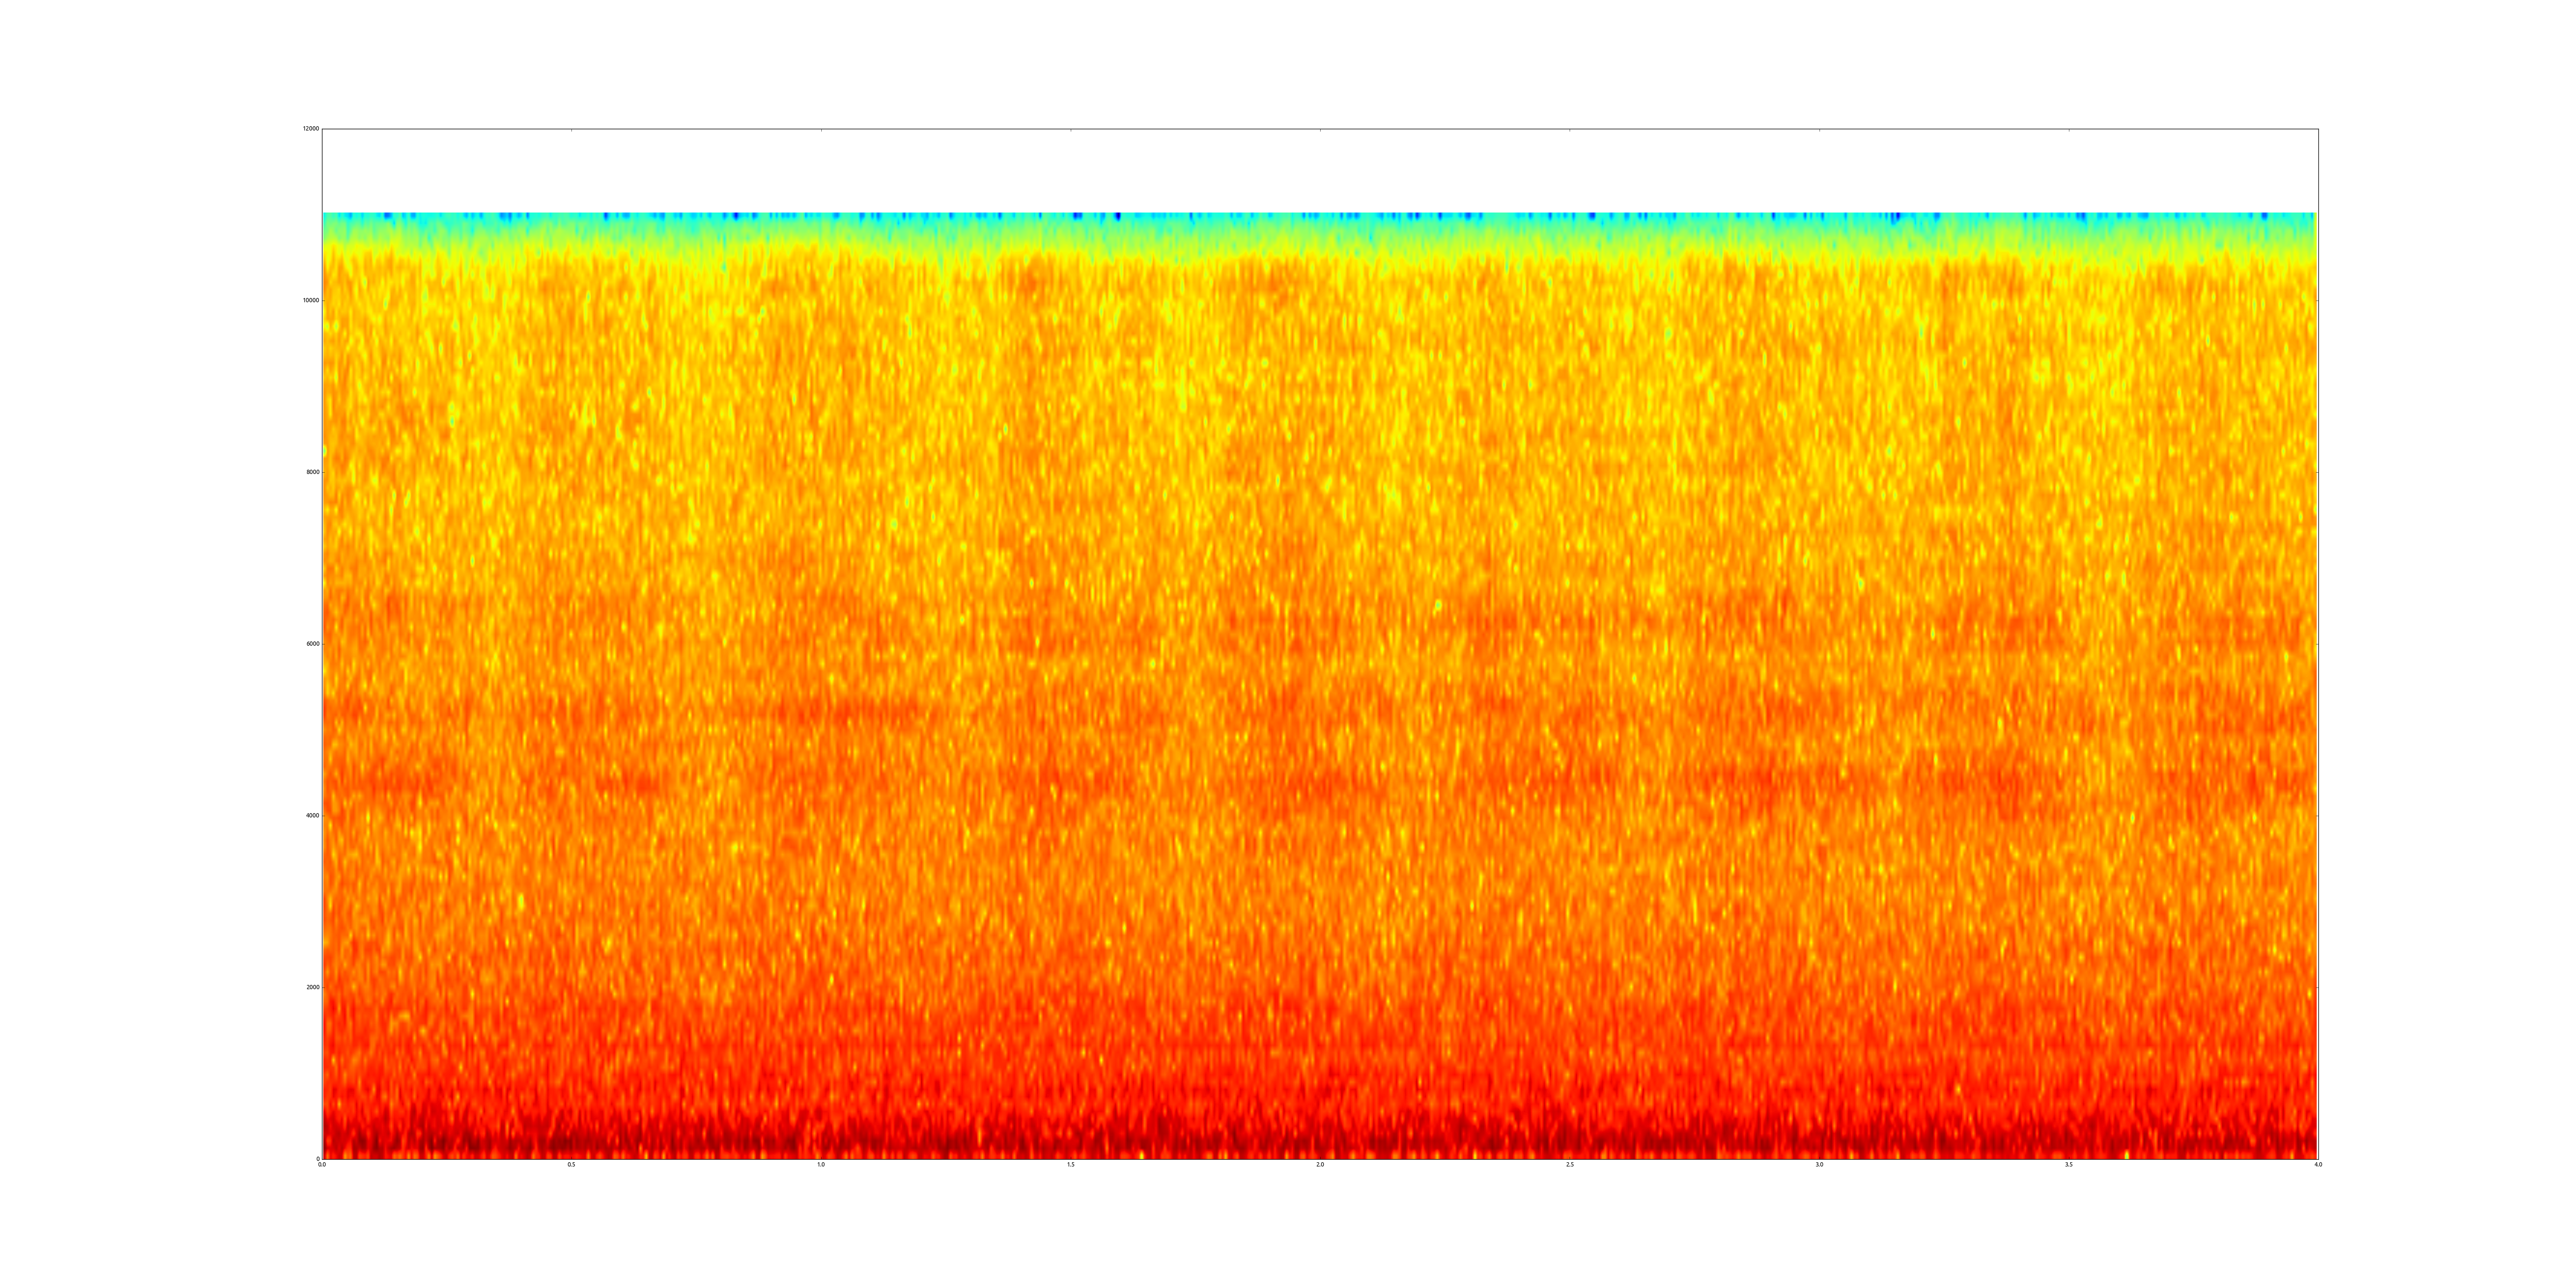

In [150]:
sample_data = train_dataset[0]
sample_question = train_dataset[0][1]["content"][1]["text"]
sample_answer = train_dataset[0][2]["content"][0]["text"]
sample_image = train_dataset[0][1]["content"][0]["image"]

print(sample_question)
print(sample_answer)
sample_image

In [151]:
if device == "cuda":
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )
    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
        MODEL_ID, 
        device_map="auto", 
        quantization_config=bnb_config,
        use_cache=False
        )

else:
    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
        MODEL_ID, 
        use_cache=False
        )
    
processor = Qwen2_5_VLProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right"

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


In [154]:
def text_generator(sample_data):
    text = processor.apply_chat_template(
        sample_data[:2], tokenize=False, add_generation_prompt=True
    )

    print(f"Prompt: {text}")
    print("-"*30)

    image_inputs = sample_data[1]["content"][0]["image"]

    inputs = processor(
        text=[text],
        images = image_inputs,
        return_tensors="pt"
    )
    inputs = inputs.to(device)

    generated_ids = model.generate(**inputs, max_new_tokens=MAX_SEQ_LEN)

    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True
    )
    del inputs
    actual_answer = sample_data[2]["content"][0]["text"]
    return output_text[0], actual_answer
    

generated_text, actual_answer = text_generator(sample_data)
print(f"Generated Answer: {generated_text}")
print(f"Actual Answer: {actual_answer}")

Prompt: <|im_start|>system
You are an expert audio analyst trained to classify environmental sound events using spectrogram images derived from the UrbanSound dataset. Your task is to analyze a given spectrogram and determine the most likely sound class it represents.

The possible sound classes are:
  "air_conditioner",
  "car_horn",
  "children_playing",
  "dog_bark",
  "drilling",
  "engine_idling",
  "gun_shot",
  "jackhammer",
  "street_music"


Respond only with the most likely sound class from the list above.Dont include any additional text or explanations in your response.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Classify the sound in this spectrogram.<|im_end|>
<|im_start|>assistant

------------------------------


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [133]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=8,
    bias="none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
)

print(f"Before adapter parameters: {model.num_parameters()}")
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters() # After LoRA trainable parameters increases. Since we add adapter.

Before adapter parameters: 3754622976
trainable params: 1,843,200 || all params: 3,756,466,176 || trainable%: 0.0491


In [134]:
training_args = SFTConfig(
    output_dir="./qwen2vl-7b-urbansound",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_checkpointing=GRADIENT_CHECKPOINTING,
    learning_rate=LEARNING_RATE,
    logging_steps=LOGGING_STEPS,
    eval_steps=EVAL_STEPS,
    eval_strategy=EVAL_STRATEGY,
    save_strategy=SAVE_STRATEGY,
    save_steps=SAVE_STEPS,
    metric_for_best_model=METRIC_FOR_BEST_MODEL,
    load_best_model_at_end=LOAD_BEST_MODEL_AT_END,
    max_grad_norm=MAX_GRAD_NORM,
    warmup_steps=WARMUP_STEPS,
    dataset_kwargs=DATASET_KWARGS,
    max_seq_length=MAX_SEQ_LEN,
    remove_unused_columns = REMOVE_UNUSED_COLUMNS,
    optim=OPTIM,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [135]:
collate_sample = [train_dataset[0], train_dataset[1]] # for batch size 2.

def collate_fn(examples):
    texts = [processor.apply_chat_template(example, tokenize=False) for example in examples]
    image_inputs = [example[1]["content"][0]["image"] for example in examples]

    batch = processor(
        text=texts, images=image_inputs, return_tensors="pt", padding=True
    )
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    batch["labels"] = batch["input_ids"]

    return batch

collated_data = collate_fn(collate_sample)
print(collated_data.keys())  # dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'labels'])

dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw', 'labels'])


In [136]:
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
    processing_class=processor.tokenizer,
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [137]:
print("-"*30)
print("Initial Evaluation")
metric = trainer.evaluate()
print(metric)
print("-"*30)

print("Training")
trainer.train()
print("-"*30)

------------------------------
Initial Evaluation


{'eval_loss': 8.305704116821289, 'eval_model_preparation_time': 0.0001, 'eval_runtime': 2.5503, 'eval_samples_per_second': 4.313, 'eval_steps_per_second': 4.313}
------------------------------
Training


------------------------------


In [138]:
trainer.save_model(training_args.output_dir)

In [139]:
import gc
import time

# https://huggingface.co/learn/cookbook/en/fine_tuning_vlm_trl
def clear_memory():
    if "inputs" in globals():
        del globals()["inputs"]
    if "model" in globals():
        del globals()["model"]
    if "processor" in globals():
        del globals()["processor"]
    if "trainer" in globals():
        del globals()["trainer"]
    if "peft_model" in globals():
        del globals()["peft_model"]
    if "bnb_config" in globals():
        del globals()["bnb_config"]
    time.sleep(2)

    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")


clear_memory()

GPU allocated memory: 0.00 GB
GPU reserved memory: 0.00 GB


In [140]:
if device == "cuda":
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )
    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
        MODEL_ID, 
        device_map="auto", 
        quantization_config=bnb_config,
        use_cache=True
        )

else:
    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
        MODEL_ID, 
        use_cache=True
        )
    
processor = Qwen2_5_VLProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right"

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


In [141]:
print(f"Before adapter parameters: {model.num_parameters()}")
model.load_adapter("./qwen2vl-7b-urbansound")
print(f"After adapter parameters: {model.num_parameters()}")

Before adapter parameters: 3754622976
After adapter parameters: 3756466176


In [147]:
sample_data = test_dataset[5]
generated_text, actual_answer = text_generator(sample_data)
print(f"Generated Answer: {generated_text}")
print(f"Actual Answer: {actual_answer}")

Prompt: <|im_start|>system
You are an expert audio analyst trained to classify environmental sound events using spectrogram images derived from the UrbanSound dataset. Your task is to analyze a given spectrogram and determine the most likely sound class it represents.

The possible sound classes are:
  "air_conditioner",
  "car_horn",
  "children_playing",
  "dog_bark",
  "drilling",
  "engine_idling",
  "gun_shot",
  "jackhammer",
  "street_music"


Respond only with the most likely sound class from the list above.Dont include any additional text or explanations in your response.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Classify the sound in this spectrogram.<|im_end|>
<|im_start|>assistant

------------------------------


Generated Answer: system
You are an expert audio analyst trained to classify environmental sound events using spectrogram images derived from the UrbanSound dataset. Your task is to analyze a given spectrogram and determine the most likely sound class it represents.

The possible sound classes are:
  "air_conditioner",
  "car_horn",
  "children_playing",
  "dog_bark",
  "drilling",
  "engine_idling",
  "gun_shot",
  "jackhammer",
  "street_music"


Respond only with the most likely sound class from the list above.Dont include any additional text or explanations in your response.
user
Classify the sound in this spectrogram.
assistant
engine_idling
Actual Answer: children_playing
